# Exam Randomizer - Documented notebook

## About

Authors: Alexander BINDER, Matthieu DE MARI

Email: alexander_binder@sutd.edu.sg, matthieu_demari@sutd.edu.sg

## Description

This is a notebook used to generate random quizzes in the Deep Learning class (2020) at the Singapore University of Technology and Design (SUTD). It breaks down in simple steps how we:
- proceeded to define randomized values for the tasks parameters in the exam,
- generated different students and teachers PDFs from a TeX template using Python,
- encrypted the PDF file with a randomly generated password, unique for each student,
- proceeded to mail the students individually, with their own version of the encrypted PDF and their password.

In this tutorial, the sending is done using a gmail account. Prof. Alexander Binder has managed to use his own sutd.edu.sg address to send the emails, but the procedure is much trickier and requires the use of a non-native library (O365 - https://pypi.org/project/O365/), Microsoft Azure APIs, and more importantly approval from SUTD IT department for the use of such APIs.

We may (or may not add) a tutorial on the procedure to follow to send emails in Python using an SUTD Office 365 mailing address instead. For now, feel free to contact him if you're interested in the procedure. 

## About additional files

Three files are needed to send the exam to the students of you class:
- The first file (studentids.csv) is a .csv file containing the list of IDs (7 digits numbers) for the students in your class. this can be easily retrieved from eDimension.
- The second one (latex_file_for_demo.tex) is a LaTeX template for your exam. It contains a few placeholders (#raXX, with XX being numbers), which are positioned in lieu of the values to be randomized later on for each of the students. We will discuss these later on.

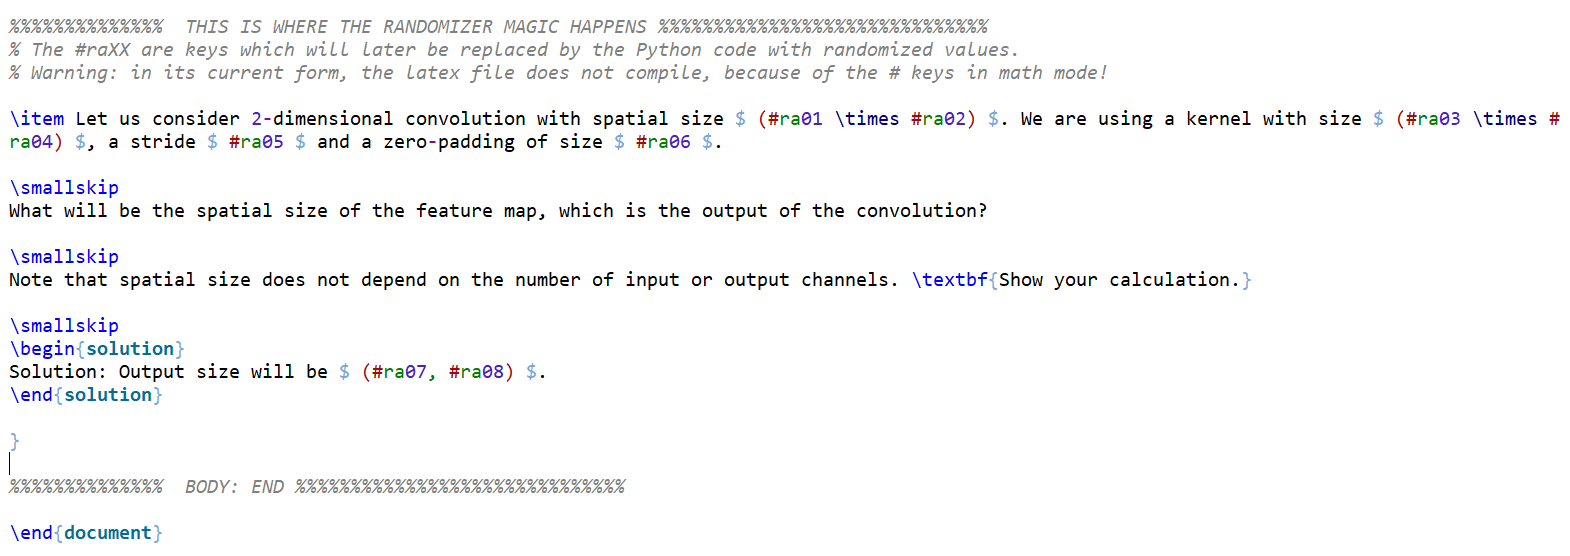

- The third one is this notebook, containing the Python fucntion to be used.

## Necessary imports

The libraries below need to be installed and imported. Most of them are native.

In [ ]:
import numpy as np
import os
import subprocess
import math
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

### MikTeX (or any other pdflatex command line compiler)

You need to install a LaTeX distribution (such as MikTeX - https://miktex.org/). This LaTeX distribution should be able to compile using pdflatex in a command-line prompt.

### PDF command line (Windows)

In order to encrypt the PDF with a password, we use PDFTK Server (https://www.pdflabs.com/tools/pdftk-server/). Check after install that you can use the pdftk command in an console.

## II. Preparing students IDs and passwords

### II.1. Retrieving students ID list from CSV file

The first function read the .csv file containing the students IDs, and return a list of strings containing each of the students IDs.

In [ ]:
def retrieve_student_list_IDs():
    
    # CSV file name
    studentidentifiers_file = './studentids.csv'
    
    # Initialize list of students ID as an empty list
    studentidentifiers = []
    
    # Open file as text and read each line
    with open(studentidentifiers_file,'r') as f:
        for line in f:
            # Read line and strip
            v = line.rstrip()
            
            # This is a cheap way to ignore things that are not student IDs
            if len(v) >= 2:
                # If it is an ID, append to list of IDs
                studentidentifiers.append(v)
                
    '''
    FOR DEBUGGING: Ignore.
    '''
    if len(studentidentifiers) == 0:
        print('len(studentidentifiers)==0')
        exit()
        
    return studentidentifiers

In [ ]:
studentidentifiers = retrieve_student_list_IDs()
print(studentidentifiers)

### II.2. Generating passwords for students

This function will be used to generate individual passwords for each of the students.

In [ ]:
def pseudopwgen():
    
    # String containing all usable characters for password generation
    chars = 'zxcvbnmasdfghjklqwertyuiop1234567890-?!@#$%^&*(='
    
    # Length of password
    pwlength = 12
    
    # Random generator for password
    # inds is a list of pwlength = 12 indexes, with values in [0, len(chars)]
    inds = np.random.choice(len(chars), size = pwlength, replace = True, p = None)
    
    # Initialize password as an empty string
    pseudopw = ''
    
    # Add randomly selected characters from chars to pseudopw
    for k in range(pwlength):
        pseudopw += chars[inds[k]]
        
    return pseudopw

In [ ]:
generated_password = pseudopwgen()
print(generated_password)

### II.3. Matching passwords and IDs

This function allows to generate password for each of the students IDs contained in the .csv file. It returns a dictionnary containing the IDs of all students as keys, and their individual passwords as values.

In [ ]:
def generate_ID_password():
    
    # Retrieve list of students IDs
    studentidentifiers = retrieve_student_list_IDs()
    number_students = len(studentidentifiers)
    
    # Generate passwords
    studentpws = [pseudopwgen() for _ in range(number_students)]
    
    # Dictionary of matching values
    id_password_dict = {studentidentifiers[i]: studentpws[i] for i in range(number_students)}
    
    return id_password_dict

In [ ]:
id_password_dict = generate_ID_password()
print(id_password_dict)

### II.4. Save passwords and IDs to file

Just in case, we provide a function that write the IDs and passwords to a file (studentpasswords.txt), shall the passwords be required.

In [ ]:
def save_ID_password(id_password_dict):
    
    with open('studentpasswords.txt', 'w') as f:
        for key, value in id_password_dict.items():
            f.write("{} - {}\n".format(key, value))
        f.close()

In [ ]:
save_ID_password(id_password_dict)

## III. Randomizing values on tasks

### III.1. Randomizing values for a given task

In order to randomize the parameters in a given task, we use the following type of custom solutionscrubber objects. Let us demonstrate here with task 1, question a. If you plan to use more questions in your exam, you will have to create additional objects.

The solutionscrubber_t1a object has a few attributes:
- scrubkeys: a list of placeholders (#raXX) used in task 1a, in the LaTeX file,

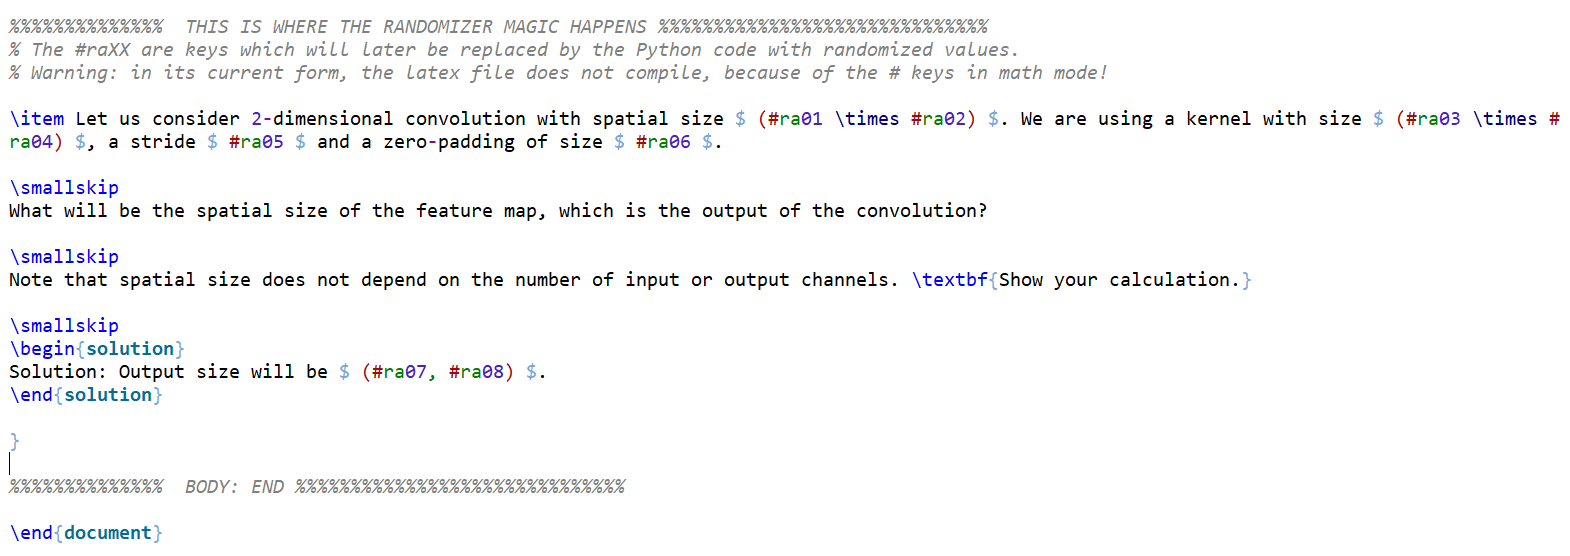

- random_values_dict_all: admissible values to choose from for each of the placeholders,
- random_values_dict_student: a dictionnary containing the placeholder string as key, and a randomly chosen value among the admissible ones in random_values_dict_all,
- dict_student_solutions: a dictionnary containing the placeholder string as key, and the computed result/solution, for the parameters chosen in random_values_dict_student.

Three methods are available:
- The randomize_values() method chooses a random value among the admissible ones for the task parameters,
- The compute_solution() computes the expected solution for the student, given the random parameters chosen by the randomize_values() method.

In [ ]:
class solutionscrubber_t1a():
    
    def __init__(self, studentid_as_seed):
        
        # Use the student ID as seed
        # Remeber to convert student ID from str to int!
        self.studentid_as_string = studentid_as_seed
        self.studentid_as_seed = int(self.studentid_as_string)
        np.random.seed(self.studentid_as_seed)
        
        # Scrub keys to look for in LaTeX file
        # '#ra01' = img size 1, 
        # '#ra02' = img size 2,
        # '#ra03' = kernel size 1
        # '#ra04' = kernel size 2
        # '#ra05' = stride
        # '#ra06' = padding size
        self.scrubkeys = ['#ra01', '#ra02', '#ra03', '#ra04', '#ra05', '#ra06']
        
        # Dict of all acceptable random values
        self.random_values_dict_all = {'#ra01': [32, 64, 128, 256, 512],
                                       '#ra02': [32, 64, 128, 256, 512],
                                       '#ra03': [3, 5, 7],
                                       '#ra04': [3, 5, 7],
                                       '#ra05': [1, 2, 3],
                                       '#ra06': [1, 2, 3]}
        
        # Dict of values for given student
        # Initialized as None for now
        self.random_values_dict_student = {key: None for key in self.scrubkeys}
        
        # Randomize values
        self.randomize_values()
        
        # Dict of values for given student (solutions)
        # '#ra07' = output size 1
        # '#ra08' = output size 2
        self.dict_student_solutions = {'#ra07': None, '#ra08': None}
        
        # Compute solutions
        self.compute_solution()
        
        
    def randomize_values(self):
        
        for key in self.random_values_dict_student.keys():
            # Get a random val for each key among the possible choices given in self.random_values_dict_all
            random_val = np.random.choice(self.random_values_dict_all[key])
            
            # Assign it to self.random_values_dict_student
            self.random_values_dict_student[key] = random_val
            

    def compute_solution(self):
        
        # Retrieve parameters: image size
        imgsize_h = self.random_values_dict_student['#ra01']
        imgsize_w = self.random_values_dict_student['#ra02']
        
        # Retrieve parameters: kernel size
        ksize_h = self.random_values_dict_student['#ra03']
        ksize_w = self.random_values_dict_student['#ra04']
        
        # Retrieve parameters: stride size
        stride = self.random_values_dict_student['#ra05']
        
        # Retrieve parameters: padding size
        pad =  self.random_values_dict_student['#ra06']
        
        # Compute solutions
        self.dict_student_solutions['#ra07'] = math.floor((imgsize_h - ksize_h + 2*pad)/float(stride) + 1)
        self.dict_student_solutions['#ra08'] = math.floor((imgsize_w - ksize_w + 2*pad)/float(stride) + 1)

In [ ]:
student_id = '0002403'
scrubber_for_task1a_given_student = solutionscrubber_t1a(studentid_as_seed = student_id)
#print(scrubber_for_task1a_given_student.__dict__, end = '\n\n')
print(scrubber_for_task1a_given_student.random_values_dict_all, end = '\n\n')
print(scrubber_for_task1a_given_student.random_values_dict_student, end = '\n\n')
print(scrubber_for_task1a_given_student.dict_student_solutions, end = '\n\n')

### III.2. Inputing into LaTeX file

The next step is to replace the placeholders (#raXX) in the LaTeX file with the randomly chosen values, stored in the solutionscrubbers object for the given student. It is simply done so by reading the TeX code from the LaTeX template, in text format, and replacing the placeholder with their numerical randomly chosen value. 
This method also creates a subfolder ./students_pdf/ and subfolders using the students ID as directory names. It creates the custom TeX code for the student in this subfolder.
This method also creates a subfolder ./teachers_pdf/ and subfolders using the students ID as directory names. It creates the custom TeX code for the teacher in this subfolder (this one has solutions printed after compilation!).

In [ ]:
def input_randomized_values_into_latex(task_scrubber_object):
    
    # Make a copy of the original template
    student_id = task_scrubber_object.studentid_as_string
    
    # Retrieve LaTeX code as string from file
    path_to_original_file = './latex_file_for_demo.tex'
    with open(path_to_original_file, 'r') as f:
        latex_code_as_string = f.read()
        f.close()
        
    # Replace randomized values in LaTeX string
    for key, val in task_scrubber_object.random_values_dict_student.items():
        latex_code_as_string = latex_code_as_string.replace(str(key), str(val))
    
    # Replace solutions in LaTeX string
    for key, val in task_scrubber_object.dict_student_solutions.items():
        latex_code_as_string = latex_code_as_string.replace(str(key), str(val))
    
    # Check for existing directory, otherwise create it
    sub_dir = './students_pdfs/'
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    stud_dir = sub_dir + '{}/'.format(student_id)
    if not os.path.exists(stud_dir):
        os.mkdir(stud_dir)
    
    # Rewrite to file (student copy)
    path_to_new_file = stud_dir + 'latex_file_for_demo_{}.tex'.format(student_id)
    with open(path_to_new_file, 'w') as f:
        f.write(latex_code_as_string)
        f.close()
        
    # Make master copy with solutions
    latex_code_as_string = latex_code_as_string.replace('noanswers', 'answers')
    
    # Rewrite to file (solutions copy)
    sub_dir2 = './teachers_pdfs/'
    if not os.path.exists(sub_dir2):
        os.mkdir(sub_dir2)
    teacher_dir = sub_dir2 + '{}/'.format(student_id)
    if not os.path.exists(teacher_dir):
        os.mkdir(teacher_dir)
    path_to_new_file = teacher_dir + 'latex_file_for_demo_{}_solutions.tex'.format(student_id)
    with open(path_to_new_file, 'w') as f:
        f.write(latex_code_as_string)
        f.close()

In [ ]:
input_randomized_values_into_latex(task_scrubber_object = scrubber_for_task1a_given_student)

## III.3. Compile LaTeX file from python

Next, we compile the generated PDFs (student and teacher copy) using Python. This is done by reusing the command line pdflatex.

In [ ]:
def compile_for_student_windows(student_id, remove = False):
    
    # Compile LaTeX file (student copy)
    sub_dir = './students_pdfs/'
    stud_dir = sub_dir + '{}/'.format(student_id)
    path_to_new_file = stud_dir + 'latex_file_for_demo_{}.tex'.format(student_id)
    os.system("pdflatex -halt-on-error -output-directory {} {}".format(stud_dir, path_to_new_file))
    
    # Compile LaTeX file (solutions copy)
    sub_dir2 = './teachers_pdfs/'
    teacher_dir = sub_dir2 + '{}/'.format(student_id)
    path_to_new_file = teacher_dir + 'latex_file_for_demo_{}_solutions.tex'.format(student_id)
    os.system("pdflatex -halt-on-error -output-directory {} {}".format(stud_dir, path_to_new_file))
    
    # Remove extra files (just leave the PDF)
    if remove:
        file = stud_dir + 'latex_file_for_demo_{}.aux'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = stud_dir + 'latex_file_for_demo_{}.log'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = stud_dir + 'latex_file_for_demo_{}.tex'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = stud_dir + 'latex_file_for_demo_{}.out'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = teacher_dir + 'latex_file_for_demo_{}_solutions.aux'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = teacher_dir + 'latex_file_for_demo_{}_solutions.log'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = teacher_dir + 'latex_file_for_demo_{}_solutions.tex'.format(student_id)
        if os.path.exists(file):
            os.remove(file)
        file = teacher_dir + 'latex_file_for_demo_{}_solutions.out'.format(student_id)
        if os.path.exists(file):
            os.remove(file)

Changing the remove to True, below, will remove everything that is not the compiled PDF in both the students and teachers subfolders. We advise to do so, in case you plan to host this subfolder on a Dropbox/Google Cloud/OneDrive online folder, as a backup plan, if the mailing fails for some reason. In that case, only share the students_pdf subfolder with your students. Giving them access to the teachers_pdf subfolder would give away the solutions to the exam!

In [ ]:
compile_for_student_windows(student_id, remove = False)

### III.4. Add password to PDF

For the student copy, we encrypt and lock the PDF with the password we generated earlier for this student. This relies on the pdftk command.

In [ ]:
def protect_pdf(student_id, password, dummy_password = 'chicken'):
    
    # Protect PDF with password
    sub_dir = './students_pdfs/'
    stud_dir = sub_dir + '{}/'.format(student_id)
    path_to_old_pdf = stud_dir + 'latex_file_for_demo_{}.pdf'.format(student_id)
    path_to_new_pdf = stud_dir + 'latex_file_for_demo_{}_pw.pdf'.format(student_id)
    query = "pdftk {} output {} owner_pw {} user_pw {}".format(path_to_old_pdf, path_to_new_pdf, \
                                                               password, dummy_password)
    # One of these should work!
    os.system(query)
    subprocess.run(query, shell = True)
    subprocess.call(query, shell = True)
    
    # Remove unprotected PDF
    if os.path.exists(path_to_old_pdf):
        os.remove(path_to_old_pdf)

In [ ]:
password = 'hello1234'
protect_pdf(student_id, password)

## IV. Sending via email, with Python

### IV.1 Retreive mail credentials and setup mailer

To send emails, we will be using the smtp/MIME library in Python. The code below works for any gmail account. Replace the gmail_user = 'youremailaddress@gmail.com' and gmail_password = 'Password' with your own credentials, to setup a mailer in Python.

You will also need to allow less secure app access in the Google security parameters of your account.

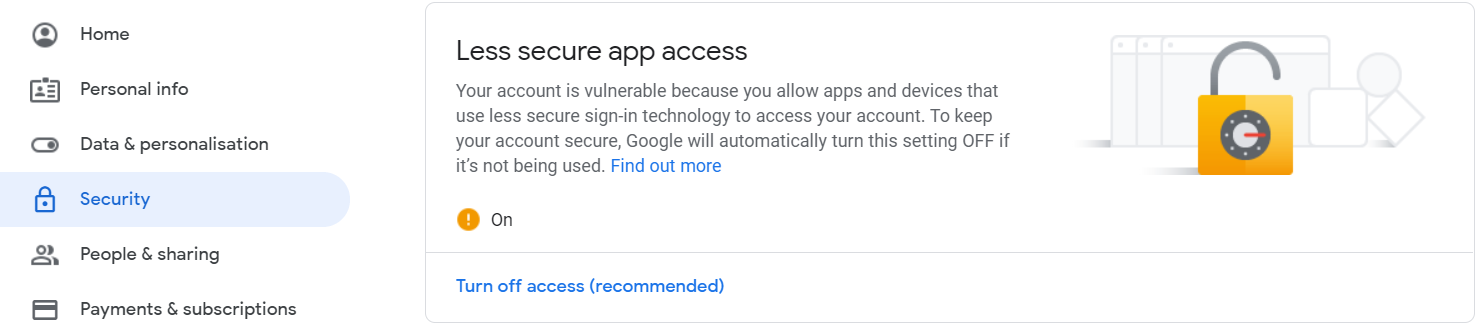

In [ ]:
def setup_mailer():
    
    gmail_user = 'youremailaddress@gmail.com'
    gmail_password = 'Password'
    
    try:
        server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
        server.ehlo()
        server.login(gmail_user, gmail_password)
    except:
        print("Something is wrong with your email credentials. Check setup_mailer() function.")
    return server

In [ ]:
mailer = setup_mailer()

In [ ]:
print(mailer.__dict__)

### IV.2. Send PDF and password to student via mail

This function defines the body, subject and attachments of the email to be sent to a student. While long, the function is extensively documented.

In [ ]:
def send_pdf_to_student(mailer, student_id, password, target_email):
    
    # 1. Prepare email
    # - Body as string
    body_str = 'Hello there!\n'
    body_str += 'This is an automated email, for student {}, with a password protected PDF!\n'.format(student_id)
    body_str += 'To unlock your PDF, use the following password: {}.\n'.format(password)
    body_str += 'Good luck on your exam!\n'
    body_str += 'Best regards,\n'
    body_str += 'Matthieu\n'
    # - Create instance of MIMEMultipart 
    msg = MIMEMultipart() 
    # - Sender   
    msg['From'] = mailer.user
    # - Recipient 
    msg['To'] = target_email 
    # - Subject  
    msg['Subject'] = 'Secret exam with password protected PDF attached and password in the body of this email!'
    # - Body
    msg.attach(MIMEText(body_str, 'plain'))
    
    # 2. Retrieve PDF file and attach to mail
    # - Retrieve PDF
    sub_dir = './students_pdfs/'
    stud_dir = sub_dir + '{}/'.format(student_id)
    path_to_pdf = stud_dir + 'latex_file_for_demo_{}_pw.pdf'.format(student_id)
    f = open(path_to_pdf, 'rb')
    # - Initialize instance of MIMEBase and named as p 
    p = MIMEBase('application', 'octet-stream') 
    p.set_payload((f).read()) 
    # - Encode into base64
    encoders.encode_base64(p)
    # - Attach to mail.
    p.add_header('Content-Disposition', "attachment; filename= %s" % path_to_pdf)
    msg.attach(p)
    
    # 3. Send mail
    try:
        mailer.login(mailer.user, mailer.password)
        mailer.sendmail(mailer.user, target_email, msg.as_string())
        mailer.close()
        status = True
    except:
        print("Something is wrong with your email credentials. Check send_pdf_to_student() function.")
        status = False
    return status

In [ ]:
target_email = 'matthieu.de.mari@gmail.com'
status = send_pdf_to_student(mailer, student_id, password, target_email)

## V. Run all!

Fianlly, we assemble the whole procedure into a single run_all() function.

In [ ]:
def run_all(make_it_official = False):
    
    # Display
    print("Starting randomized exam generation...")
    
    # 1. Generate ID-password combinations
    id_password_dict = generate_ID_password()
    save_ID_password(id_password_dict)
    
    # Display
    print("---")
    print("1. Generated ID-password combinations. Displaying below.")
    print(id_password_dict)
    print("---")
    
    # For each student
    for student_id, password in id_password_dict.items():
        # Display
        print("-")
        print("Exam generation for student {}.".format(student_id))
        
        # 2.a Generate randomized task 1 values (repeat for all tasks)
        scrubber_for_task1a_given_student = solutionscrubber_t1a(studentid_as_seed = student_id)
        
        # 2.b Insert value for task 1 into LaTeX (repeat for all tasks)
        input_randomized_values_into_latex(task_scrubber_object = scrubber_for_task1a_given_student)
        
        # 2.c. Compile LaTeX
        compile_for_student_windows(student_id, remove = True)
        
        # 2.d. Password protection
        protect_pdf(student_id, password)
        
        # Display
        print("Exam generation complete.")
        
    # Display
    print("---")
    print("2. Generated all encrypted PDFs.")
    
    # Setup mailer
    mailer = setup_mailer()
        
    # For each student
    for student_id, password in id_password_dict.items():
        print("-")
        print("Sending email to student {}.".format(student_id))
        
        # 3. Send email to student
        if not make_it_official:
            target_email = 'test_email@somewhere.com'
        else:
            target_email = '{}@mymail.sutd.edu.sg'.format(student_id)
        status = send_pdf_to_student(mailer, student_id, password, target_email)
        assert status, "There is an error in your mailer function." \
            + "Please investigate your setup_mailer() and send_pdf_to_student() functions."
        
        # Display
        print("Email to student {} has been sent.".format(student_id))

    # Display
    print("3. Emails have been sent to students.")
    print("---")
    print("Task completed.")

**IMPORTANT NOTE: If you uncomment the line below and leave make_it_official to False, it will send emails to the address you specified at line 51 of the block above (target_email = 'test_email@somewhere.com'). This is done for testing purposes only, so that you can visualize your emails and test the PDFs/passwords beforehand.**

**Changing the make_it_official parameter of the run_all() function will send email to the students whose IDs were listed in the .csv file. Do not use until you're 100% ready to do so!**

In [ ]:
#run_all(make_it_official = False)